# **Brief description of the problem and data**

This Kaggle competition is a binary image classification problem to identify metastatic cancer in small image patches taken from larger digital pathology scans. The dataset contains a large number of pathology images where a positive label indicates that the center 32x32 pixel region of the patch contains at least one pixel of tumor tissue. The outer region of the patch was provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image. Tumor tissue in the outer region of the patch will not influence the label. The goal is to predict the labels for the images in the test folder while the train_labels.csv file provides the ground truth for the images in the train folder. All files are named with an image id and the dataset does not include duplicates.

Data source: https://www.kaggle.com/competitions/histopathologic-cancer-detection/data

# **Load Libraries**

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tifffile import imread
import keras,os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
os.system('pip install visualkeras')
import visualkeras

# **Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data**

In [3]:
train_path = '../input/histopathologic-cancer-detection/train/'
sample_submission = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
train_data = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
train_data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [5]:
train_data.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Columns: 2 entries, id to label
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [6]:
train_data['label'].value_counts().to_frame()

,label
0,130908
1,89117


<AxesSubplot:title={'center':'Labels'}, xlabel='label'>

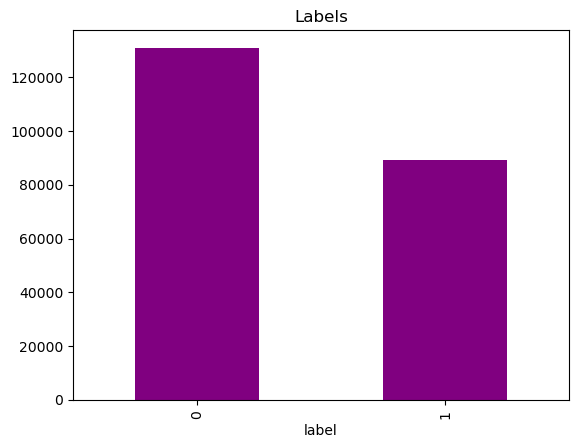

In [7]:
train_data.groupby(['label'])['label'].count().plot(kind='bar', color = 'purple', title='Labels')

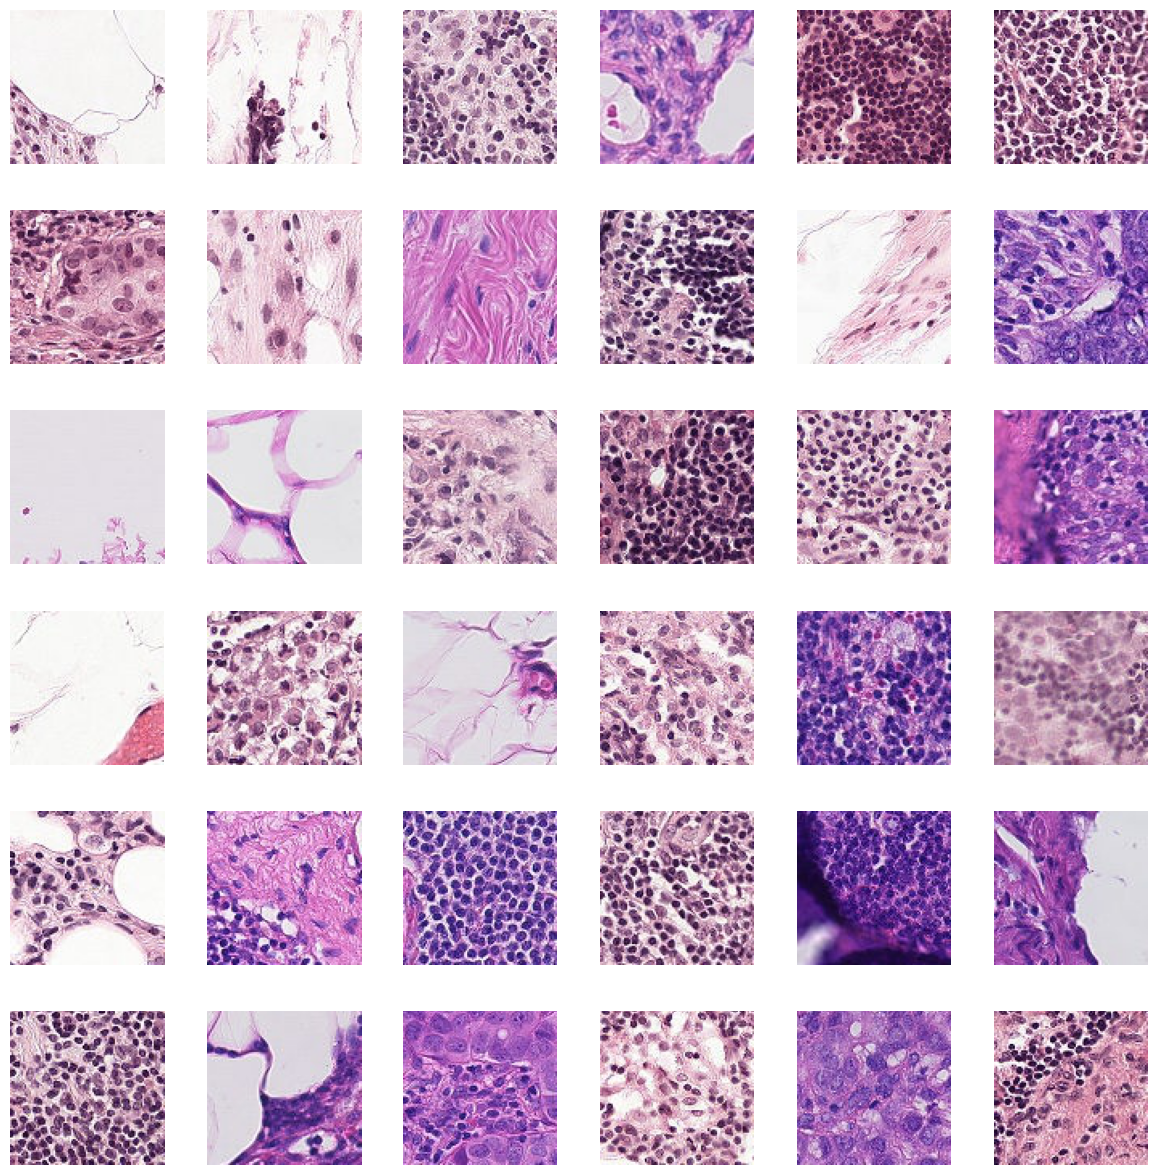

In [8]:
images_train = train_data
images_train['label'] = images_train['label'].astype(str)
images_train['id'] = train_data['id'] + '.tif'

rows, cols = 6, 6

fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

for i in range(6 * 6):
    image = imread(train_path + images_train['id'][i])

    row, col = i // cols, i % cols

    axes[row, col].imshow(image)
    axes[row, col].axis('off')

plt.subplots_adjust(wspace = 0.1, hspace = 0.3)

plt.show()

From the exploratory data analysis of the training data, it is observed:

* There are 220,025 entries and 2 columns:
    * ID - numeric representing an image file
    * Label -  object representing if the 32x32 patch in the image contains at least one pixel of tumor tissue
* 60% of the images are labeled negative (0 = no_tumor_tissue) versus positive (1 = has_tumor_tissue)
* There are no missing values and as stated in the description of the data,there are no duplicates

It is not possible to easily label the data through visualization inpsection of the images with the human eye.

# **Model Architecture**

The initial model is a convolutional neural network (CNN) model starting with multiple 2D convolutional layers using the relu activation function followed by a max pooling layer each time.  The model is then flattened before using the sigmoid activation function in the final layer for binary classification.

In [ ]:
model1 = Sequential()

model1.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model1.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))

model1.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model1.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))

model1.add(Flatten())
model1.add(Dense(units=256, activation='relu'))
model1.add(Dense(units=1, activation='sigmoid'))

batch_size = 256

model1.build(input_shape=(batch_size, 64, 64, 3))

model1.summary()

This relatively simple model results in 1,401,617 trainable parameters. Below, the model will be compiled using Adam as an optimizer with the default learning rate, binary crossentropy as the loss function and accuracy as the evaluation metric. 

In [ ]:
model1.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
visualkeras.layered_view(model1, legend=True)

The Visualkeras image provides a clear image of this model.

# **Results and Analysis**

The training data is normalized and split - training (80%) and validation(20%) before fitting it to the model using 10 epochs.

In [13]:
generator = ImageDataGenerator(rescale=1/255, validation_split=0.20)

data_train = generator.flow_from_dataframe(
    dataframe = images_train,
    x_col='id', 
    y_col='label', 
    directory=train_path,
    subset='training',
    class_mode='binary',
    batch_size=batch_size,
    target_size=(64, 64))

data_validate=generator.flow_from_dataframe(
    dataframe=images_train,
    x_col='id',
    y_col='label',
    directory=train_path,
    subset="validation",
    class_mode='binary',
    batch_size=batch_size,
    target_size=(64, 64))

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [ ]:
model1_hist = model1.fit(data_train, validation_data=data_validate, epochs=10)

In [ ]:
model1_hist.history

In [ ]:
accuracy = model1_hist.history['accuracy']
val_accuracy = model1_hist.history['val_accuracy']
loss = model1_hist.history['loss']
val_loss = model1_hist.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Model1 - Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Model1 - Training and Validation Loss')
plt.show()

The training accuracy has a consistent upwards slope, peaking at 91.5% while the training loss reflects consistent downward slope.  In contrast, the validation accuracy and loss show more fluctuation.  This suggests the possibility that we are over/under fitting. 

We will modify some of the hyperparameters to see if we can improve performance in a second model.  To overcome the overfitting, we will insert a batch normalization layer between the convolution and activation layers.  This modification can regularize the model and prove model performance.  In addition, we will decrease the learning rate.

For more information on batch normalization: https://www.baeldung.com/cs/batch-normalization-cnn

In [52]:
from keras.layers import BatchNormalization, Activation
print('done')

done


In [59]:
model2 = Sequential()

model2.add(Conv2D(filters=16, kernel_size=(3,3)))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Conv2D(filters=16, kernel_size=(3,3)))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPool2D(pool_size=(2,2)))

model2.add(Conv2D(filters=32, kernel_size=(3,3)))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Conv2D(filters=32, kernel_size=(3,3)))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPool2D(pool_size=(2,2)))

model2.add(Flatten())
model2.add(Dense(units=256, activation='relu'))
#model2.add(Dropout(.3))

model2.add(Dense(units=1, activation='sigmoid'))

batch_size = 256

model2.build(input_shape=(batch_size, 64, 64, 3))

model2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (256, 62, 62, 16)         448       
                                                                 
 batch_normalization_4 (Batc  (256, 62, 62, 16)        64        
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (256, 62, 62, 16)         0         
                                                                 
 conv2d_43 (Conv2D)          (256, 60, 60, 16)         2320      
                                                                 
 batch_normalization_5 (Batc  (256, 60, 60, 16)        64        
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (256, 60, 60, 16)       

In [60]:
o = Adam(learning_rate=0.0001)
model2.compile(optimizer=o, loss='binary_crossentropy', metrics=['accuracy'])
print('done')

done


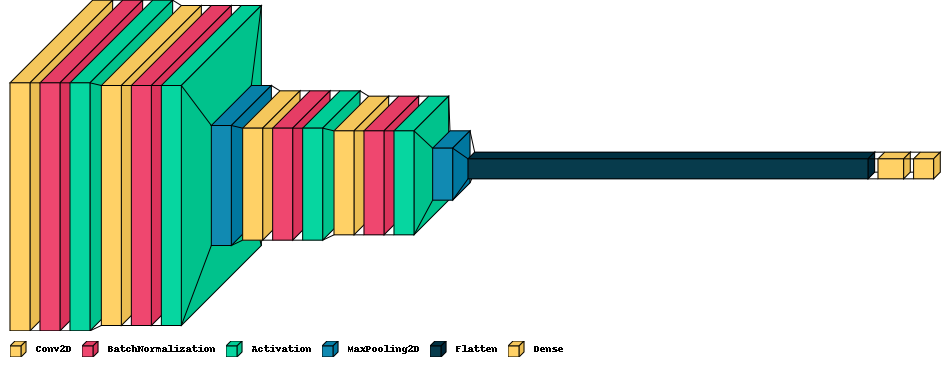

In [61]:
visualkeras.layered_view(model2, legend=True)

In [62]:
model2_hist = model2.fit(data_train, validation_data=data_validate, epochs=10)

Epoch 1/10
688/688 [==============================] - 390s 565ms/step - loss: 0.4142 - accuracy: 0.8138 - val_loss: 0.3723 - val_accuracy: 0.8360
Epoch 2/10
688/688 [==============================] - 318s 462ms/step - loss: 0.3474 - accuracy: 0.8498 - val_loss: 0.3570 - val_accuracy: 0.8464
Epoch 3/10
688/688 [==============================] - 328s 476ms/step - loss: 0.3190 - accuracy: 0.8636 - val_loss: 0.3510 - val_accuracy: 0.8501
Epoch 4/10
688/688 [==============================] - 318s 462ms/step - loss: 0.3010 - accuracy: 0.8730 - val_loss: 0.3171 - val_accuracy: 0.8669
Epoch 5/10
688/688 [==============================] - 323s 470ms/step - loss: 0.2841 - accuracy: 0.8809 - val_loss: 0.3094 - val_accuracy: 0.8699
Epoch 6/10
688/688 [==============================] - 313s 455ms/step - loss: 0.2694 - accuracy: 0.8870 - val_loss: 0.2940 - val_accuracy: 0.8764
Epoch 7/10
688/688 [==============================] - 342s 498ms/step - loss: 0.2590 - accuracy: 0.8917 - val_loss: 0.2809 -

In [ ]:
accuracy = model2_hist.history['accuracy']
val_accuracy = model2_hist.history['val_accuracy']
loss = model2_hist.history['loss']
val_loss = model2_hist.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Model2 - Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Model2 - Training and Validation Loss')
plt.show()

# **Submission**

In [ ]:
test_path = '../input/histopathologic-cancer-detection/test/'
images_test = pd.DataFrame({'id':os.listdir(test_path)})
generator_test = ImageDataGenerator(rescale=1/255)
data_test = generator_test.flow_from_dataframe(
    dataframe = images_test,
    x_col='id', # filenames
    directory=test_path,
    class_mode=None,
    batch_size=1,
    target_size=(64, 64),
    shuffle=False)

In [ ]:
predictions = model2.predict(data_test, verbose=1)
print(predictions)

In [ ]:
pred = np.transpose(predictions)[0]
submission = pd.DataFrame()
submission['id'] = images_test['id'].apply(lambda x: x.split('.')[0])
submission['label'] = list(map(lambda x: 0 if x < 0.5 else 1, pred))
print(submission.head())

In [ ]:
submission['label'].value_counts()

In [ ]:
submission.to_csv('submission.csv', index=False)

# **Conclusion**

In this Kaggle competition, two simple convolutional neural network models were creasted to solve the binary image classification problem to identify metastatic cancer in small image patches taken from larger digital pathology scans.  The two models were similarly constructed except the second model added batch normalization to address overfitting and lower learnign rate. 

The final model resulted in an accuracy score of x.xx% and a submission score of XX.  Further adjustment to hyperparameters including the number of layers, filter size and learning rate have the potential to further improve accuracy.

The results of this competition, evidence both the complexity and effectiveness of neural network models. Within only a few layers, the models quickly resulted in greater than 1 million trainable parameters while the use of TensorFlow Keras simplified the forward and backward propagation that was manually calculated in class.